In [15]:
# Code done on Google Colab using a GPU
# Data.zip was placed in content
# !unzip "/content/Data.zip"

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
from torch.utils.data import random_split

import os
import numpy as np
import matplotlib.pyplot as plt
import cv2

# I. Data Processing

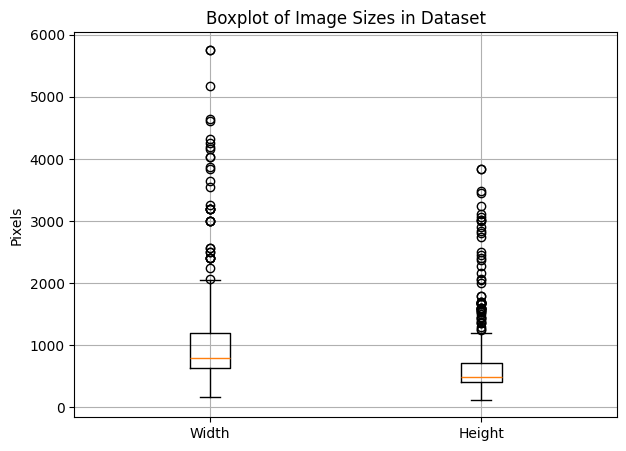

In [2]:
# Boxplot of images' shapes to get an idea
dataset_path = "potholes/"

widths = []
heights = []

# Loop through all subdirectories (class folders)
for class_folder in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_folder)

    if os.path.isdir(class_path):  # Ensure it's a folder
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)

            # Read image using OpenCV
            image = cv2.imread(image_path)
            if image is not None:
                h, w, _ = image.shape
                widths.append(w)
                heights.append(h)

widths = np.array(widths)
heights = np.array(heights)

plt.figure(figsize=(7, 5))
plt.boxplot([widths, heights], tick_labels=["Width", "Height"])
plt.ylabel("Pixels")
plt.title("Boxplot of Image Sizes in Dataset")
plt.grid(True)
plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

def get_loaders(dataset_path="potholes", size=(256,256), mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)):

  # Define Image Transformations (Resizing and Normalization)
  transform = transforms.Compose([
      transforms.Resize(size),
      transforms.ToTensor(),           # Convert to tensor
      transforms.Normalize(mean,std) # normalize pixel values
  ])

  full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

  train_size = int(0.6 * len(full_dataset))
  val_test_size = len(full_dataset) - train_size
  val_size = val_test_size // 2
  test_size = val_test_size - val_size
  train_dataset, dev_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

  # Create DataLoaders
  train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
  val_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)
  test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

  return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = get_loaders()
train_loader_resnet, val_loader_resnet, test_loader_resnet = get_loaders(size=(224,224), mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # for Resnet50: parameters used in its training

Using device: cuda


# II. Models definition

In [4]:
class PotholeCNN(nn.Module):
    def __init__(self, dropout_value=0.3):
        super(PotholeCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 64 * 64, 128)  # 64 channels * 64 * 64 (64 = 256 / 2 / 2 = 128 / 2: / 2 because of maxpooling)
        self.fc2 = nn.Linear(128, 1)  # Binary classification (pothole or normal)
        self.sigmoid = nn.Sigmoid()  # Activation function for binary classification
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))  # Sigmoid activation for binary output
        return x

In [5]:
import torchvision.models as models
from torchvision.models import ResNet50_Weights

class PotholeResNet50(nn.Module):
    def __init__(self, dropout_value=0.3, pretrained=True):
        super(PotholeResNet50, self).__init__()
        # Pre-trained ResNet50 model
        self.resnet = models.resnet50(weights=ResNet50_Weights.DEFAULT)
        # Replace the final fully connected layer for binary classification
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(dropout_value),
            nn.Linear(num_ftrs, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.resnet(x)

# III. Training

In [6]:
def plot_losses(train_losses, dev_losses):
  plt.figure(figsize=(6, 4))
  plt.plot(range(1, len(train_losses)+1), train_losses, label='Training Loss')
  plt.plot(range(1, len(dev_losses) + 1), dev_losses, label='Development Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Development Loss')
  plt.legend()
  plt.grid(True)
  plt.show()

In [7]:
def training_CNN(num_epochs, model, train_loader, dev_loader, test_loader, device, dropout_value=0.2, name_model="CNN"):

  print("===============================================================================================")
  print(f"\033[1mTraining {name_model} model with dropout = {dropout_value} \033[0;0m")

  criterion = nn.BCELoss()  # Binary Cross Entropy Loss
  optimizer = optim.Adam(model.parameters(), lr=0.001)

  train_losses = []
  dev_losses = []

  for epoch in range(num_epochs):
      total_loss = 0
      correct = 0
      total = 0

      for images, labels in train_loader:
          images, labels = images.to(device), labels.float().to(device)
          labels = labels.view(-1, 1)  # Reshape labels for BCELoss

          optimizer.zero_grad()  # Reset gradients
          outputs = model(images)  # Forward pass
          loss = criterion(outputs, labels)  # Compute loss
          loss.backward()  # Backpropagation
          optimizer.step()  # Update weights

          total_loss += loss.item()

          predictions = (outputs >= 0.5).float()  # Convert sigmoid outputs to binary (0 or 1)
          correct += (predictions == labels).sum().item()
          total += labels.size(0)

      epoch_loss = total_loss / len(train_loader)
      train_losses.append(epoch_loss)
      epoch_accuracy = correct / total

      # Evaluation on the development set
      model.eval()
      dev_loss = 0
      dev_correct = 0
      dev_total = 0

      with torch.no_grad():
          for images, labels in dev_loader:
              images, labels = images.to(device), labels.float().to(device)
              labels = labels.view(-1, 1)

              outputs = model(images)
              loss = criterion(outputs, labels)
              dev_loss += loss.item()

              predictions = (outputs >= 0.5).float()
              dev_correct += (predictions == labels).sum().item()
              dev_total += labels.size(0)

      dev_epoch_loss = dev_loss / len(dev_loader)
      dev_losses.append(dev_epoch_loss)
      dev_epoch_accuracy = dev_correct / dev_total

      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {total_loss/len(train_loader):.4f}, Train Accuracy: {epoch_accuracy:.4f}, Val Loss: {dev_epoch_loss:.4f}, Val Accuracy: {dev_epoch_accuracy:.4f}")


  plot_losses(train_losses, dev_losses)

  torch.save(model.state_dict(), "pothole_cnn.pth")

  # Testing set
  model.eval()
  test_correct = 0
  test_total = 0

  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.float().to(device)
          labels = labels.view(-1, 1)

          outputs = model(images)
          predictions = (outputs >= 0.5).float()
          test_correct += (predictions == labels).sum().item()
          test_total += labels.size(0)

  test_accuracy = test_correct / test_total
  print(f"\033[1mTest Accuracy: {test_accuracy:.4f}\033[0;0m")

In [8]:
num_epochs = 10

## CNN

Training CNN model with dropout = 0.2 
Epoch 1/10, Train Loss: 1.0770, Train Accuracy: 0.6863, Val Loss: 0.3160, Val Accuracy: 0.8750
Epoch 2/10, Train Loss: 0.2884, Train Accuracy: 0.8873, Val Loss: 0.2532, Val Accuracy: 0.8824
Epoch 3/10, Train Loss: 0.1547, Train Accuracy: 0.9338, Val Loss: 0.2442, Val Accuracy: 0.8897
Epoch 4/10, Train Loss: 0.0872, Train Accuracy: 0.9632, Val Loss: 0.1725, Val Accuracy: 0.9265
Epoch 5/10, Train Loss: 0.0382, Train Accuracy: 0.9853, Val Loss: 0.2465, Val Accuracy: 0.8897
Epoch 6/10, Train Loss: 0.0185, Train Accuracy: 0.9975, Val Loss: 0.3257, Val Accuracy: 0.8897
Epoch 7/10, Train Loss: 0.0130, Train Accuracy: 0.9975, Val Loss: 0.2201, Val Accuracy: 0.9338
Epoch 8/10, Train Loss: 0.0145, Train Accuracy: 0.9975, Val Loss: 0.1817, Val Accuracy: 0.9559
Epoch 9/10, Train Loss: 0.0276, Train Accuracy: 0.9877, Val Loss: 0.2955, Val Accuracy: 0.9191
Epoch 10/10, Train Loss: 0.0238, Train Accuracy: 0.9926, Val Loss: 0.2342, Val Accuracy: 0.9265


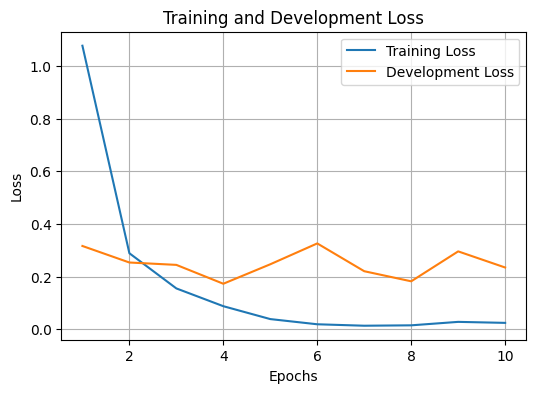

Test Accuracy: 0.8832
Training CNN model with dropout = 0.3 
Epoch 1/10, Train Loss: 1.3773, Train Accuracy: 0.5833, Val Loss: 0.5667, Val Accuracy: 0.6103
Epoch 2/10, Train Loss: 0.4507, Train Accuracy: 0.7892, Val Loss: 0.2968, Val Accuracy: 0.8603
Epoch 3/10, Train Loss: 0.2731, Train Accuracy: 0.8995, Val Loss: 0.1897, Val Accuracy: 0.9265
Epoch 4/10, Train Loss: 0.1179, Train Accuracy: 0.9583, Val Loss: 0.2278, Val Accuracy: 0.9118
Epoch 5/10, Train Loss: 0.0674, Train Accuracy: 0.9681, Val Loss: 0.5327, Val Accuracy: 0.8162
Epoch 6/10, Train Loss: 0.1395, Train Accuracy: 0.9510, Val Loss: 0.1910, Val Accuracy: 0.9118
Epoch 7/10, Train Loss: 0.0733, Train Accuracy: 0.9828, Val Loss: 0.2479, Val Accuracy: 0.9191
Epoch 8/10, Train Loss: 0.0266, Train Accuracy: 0.9926, Val Loss: 0.2536, Val Accuracy: 0.9265
Epoch 9/10, Train Loss: 0.0115, Train Accuracy: 0.9975, Val Loss: 0.2191, Val Accuracy: 0.9191
Epoch 10/10, Train Loss: 0.0043, Train Accuracy: 1.0000, Val Loss: 0.3243, Val Accur

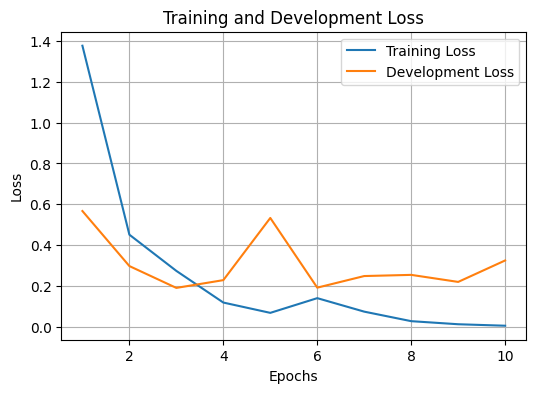

Test Accuracy: 0.8832
Training CNN model with dropout = 0.4 
Epoch 1/10, Train Loss: 2.8848, Train Accuracy: 0.5588, Val Loss: 0.6160, Val Accuracy: 0.4559
Epoch 2/10, Train Loss: 0.4875, Train Accuracy: 0.7010, Val Loss: 0.3540, Val Accuracy: 0.8382
Epoch 3/10, Train Loss: 0.3060, Train Accuracy: 0.8603, Val Loss: 0.3269, Val Accuracy: 0.8676
Epoch 4/10, Train Loss: 0.2018, Train Accuracy: 0.9289, Val Loss: 0.2430, Val Accuracy: 0.8750
Epoch 5/10, Train Loss: 0.1586, Train Accuracy: 0.9191, Val Loss: 0.2173, Val Accuracy: 0.8971
Epoch 6/10, Train Loss: 0.1039, Train Accuracy: 0.9632, Val Loss: 0.3491, Val Accuracy: 0.8897
Epoch 7/10, Train Loss: 0.0598, Train Accuracy: 0.9804, Val Loss: 0.4262, Val Accuracy: 0.8676
Epoch 8/10, Train Loss: 0.0422, Train Accuracy: 0.9902, Val Loss: 0.2823, Val Accuracy: 0.9338
Epoch 9/10, Train Loss: 0.0193, Train Accuracy: 0.9975, Val Loss: 0.2788, Val Accuracy: 0.9118
Epoch 10/10, Train Loss: 0.0087, Train Accuracy: 0.9975, Val Loss: 0.5293, Val Accur

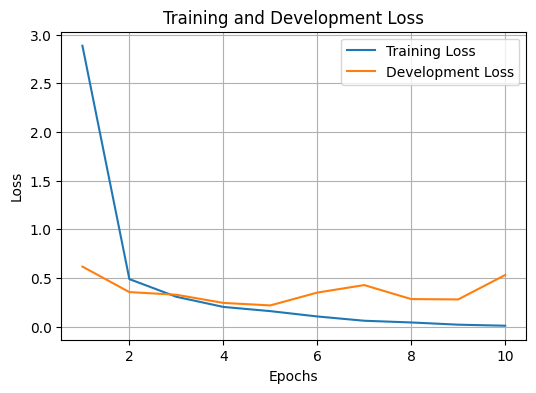

Test Accuracy: 0.8686


In [9]:
for dropout_value in [0.2, 0.3, 0.4]:
  model = PotholeCNN(dropout_value).to(device)
  training_CNN(num_epochs, model, train_loader, val_loader, test_loader, device, dropout_value)

## Resnet

Training Resnet50 model with dropout = 0.2 
Epoch 1/10, Train Loss: 0.2530, Train Accuracy: 0.9142, Val Loss: 2.9825, Val Accuracy: 0.9118
Epoch 2/10, Train Loss: 41.3526, Train Accuracy: 0.5858, Val Loss: 50.6250, Val Accuracy: 0.5147
Epoch 3/10, Train Loss: 49.5994, Train Accuracy: 0.5049, Val Loss: 50.6250, Val Accuracy: 0.5147
Epoch 4/10, Train Loss: 49.5192, Train Accuracy: 0.5049, Val Loss: 50.6250, Val Accuracy: 0.5147
Epoch 5/10, Train Loss: 49.7596, Train Accuracy: 0.5049, Val Loss: 50.6250, Val Accuracy: 0.5147
Epoch 6/10, Train Loss: 49.8397, Train Accuracy: 0.5049, Val Loss: 50.6250, Val Accuracy: 0.5147
Epoch 7/10, Train Loss: 49.7596, Train Accuracy: 0.5049, Val Loss: 50.6250, Val Accuracy: 0.5147
Epoch 8/10, Train Loss: 49.3590, Train Accuracy: 0.5049, Val Loss: 50.6250, Val Accuracy: 0.5147
Epoch 9/10, Train Loss: 49.3590, Train Accuracy: 0.5049, Val Loss: 50.6250, Val Accuracy: 0.5147
Epoch 10/10, Train Loss: 49.8397, Train Accuracy: 0.5049, Val Loss: 50.6250, Val Accu

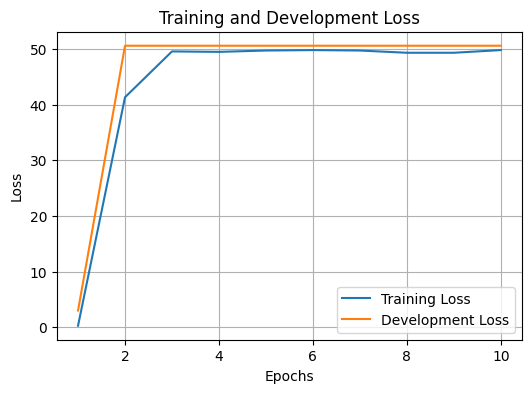

Test Accuracy: 0.3869
Training Resnet50 model with dropout = 0.3 
Epoch 1/10, Train Loss: 0.1944, Train Accuracy: 0.9167, Val Loss: 1.2228, Val Accuracy: 0.9118
Epoch 2/10, Train Loss: 2.7862, Train Accuracy: 0.5000, Val Loss: 0.6799, Val Accuracy: 0.7647
Epoch 3/10, Train Loss: 0.7709, Train Accuracy: 0.5711, Val Loss: 0.6751, Val Accuracy: 0.4853
Epoch 4/10, Train Loss: 0.6843, Train Accuracy: 0.5613, Val Loss: 0.7047, Val Accuracy: 0.5147
Epoch 5/10, Train Loss: 0.6943, Train Accuracy: 0.5319, Val Loss: 0.6752, Val Accuracy: 0.4853
Epoch 6/10, Train Loss: 0.6382, Train Accuracy: 0.6201, Val Loss: 0.4763, Val Accuracy: 0.7647
Epoch 7/10, Train Loss: 0.5736, Train Accuracy: 0.7010, Val Loss: 0.3610, Val Accuracy: 0.8309
Epoch 8/10, Train Loss: 0.4317, Train Accuracy: 0.8137, Val Loss: 0.3080, Val Accuracy: 0.8382
Epoch 9/10, Train Loss: 0.2858, Train Accuracy: 0.8725, Val Loss: 0.2577, Val Accuracy: 0.8897
Epoch 10/10, Train Loss: 0.2572, Train Accuracy: 0.9020, Val Loss: 0.2887, Val 

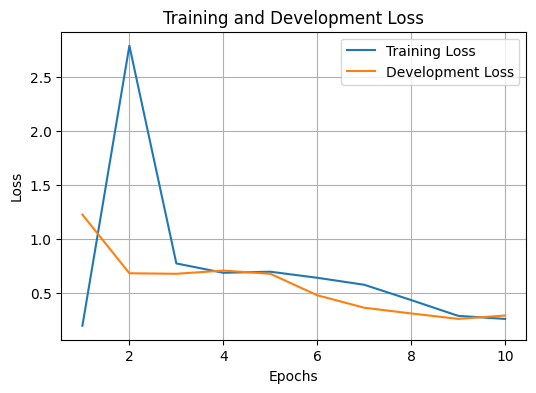

Test Accuracy: 0.9124
Training Resnet50 model with dropout = 0.4 
Epoch 1/10, Train Loss: 0.2316, Train Accuracy: 0.9020, Val Loss: 4.1810, Val Accuracy: 0.9265
Epoch 2/10, Train Loss: 43.4329, Train Accuracy: 0.5662, Val Loss: 49.3750, Val Accuracy: 0.4853
Epoch 3/10, Train Loss: 50.6410, Train Accuracy: 0.4951, Val Loss: 49.3750, Val Accuracy: 0.4853
Epoch 4/10, Train Loss: 50.5609, Train Accuracy: 0.4951, Val Loss: 49.3750, Val Accuracy: 0.4853
Epoch 5/10, Train Loss: 50.7212, Train Accuracy: 0.4951, Val Loss: 49.3750, Val Accuracy: 0.4853
Epoch 6/10, Train Loss: 50.3205, Train Accuracy: 0.4951, Val Loss: 49.3750, Val Accuracy: 0.4853
Epoch 7/10, Train Loss: 50.6410, Train Accuracy: 0.4951, Val Loss: 49.3750, Val Accuracy: 0.4853
Epoch 8/10, Train Loss: 50.4808, Train Accuracy: 0.4951, Val Loss: 49.3750, Val Accuracy: 0.4853
Epoch 9/10, Train Loss: 50.5609, Train Accuracy: 0.4951, Val Loss: 49.3750, Val Accuracy: 0.4853
Epoch 10/10, Train Loss: 50.4006, Train Accuracy: 0.4951, Val L

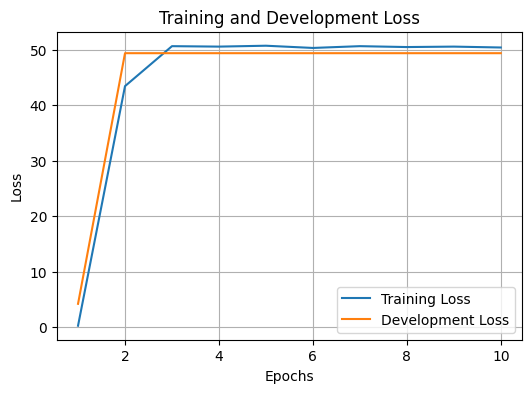

Test Accuracy: 0.6131


In [12]:
for dropout_value in [0.2, 0.3, 0.4]:
    model = PotholeResNet50(dropout_value=dropout_value).to(device)
    training_CNN(num_epochs, model, train_loader_resnet, val_loader_resnet, test_loader_resnet, device, dropout_value, name_model="Resnet50")